In [35]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
import webbrowser as web
import geopandas as gpd
from folium import plugins

In [2]:
base_date_start = '2022-07-11'
base_date_end = '2022-07-15'
base_date = '2022-07-11'

In [3]:
dir = f"{base_date_start}_to_{base_date_end}"

In [37]:
connections = [pd.read_parquet(f) for f in glob.glob(f"{dir}//output//{base_date}*.parquet")]
connections = pd.concat(connections, ignore_index = True)
connections['event_timestamp_u'] = pd.to_datetime(connections["event_timestamp_u"])
connections['event_timestamp_v'] = pd.to_datetime(connections["event_timestamp_v"])
connections['waiting_time'] = (connections.event_timestamp_v - connections.event_timestamp_u).astype('timedelta64[s]')
connections['hour'] = connections['event_timestamp_u'].dt.hour
connections.query('hour not in [0,1,2,3,4]', inplace = True)
all_pairs = pd.read_parquet(f"{dir}//all_pairs.parquet")
dim_bs = pd.read_parquet(f"{dir}//dim_bs.parquet")
clusters = pd.read_parquet(f"{dir}//clusters.parquet")

In [5]:
df_cluster = connections.merge(
    all_pairs[['dummy_id_x', 'dummy_id_y', 'dist', 'cluster']].drop_duplicates(),
    left_on = ['dummy_id_u', 'dummy_id_v'], 
    right_on = ['dummy_id_x', 'dummy_id_y'], 
    how = 'inner'
).drop(
    labels = ['dummy_id_x', 'dummy_id_y'],
    axis = 1
)

In [6]:
[len(connections), len(df_cluster)]

[7182359, 7182359]

In [7]:
walking_speed = 1 # m/s
df_cluster['walking_time'] = df_cluster['dist'] / walking_speed
df_cluster.query('walking_time < waiting_time', inplace = True)

In [8]:
agg_cluster = df_cluster.groupby('cluster').size().reset_index(name = 'conn_count')

In [9]:
agg_cluster.conn_count.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
conn_count,109.0,47959.449541,71079.785419,18.0,9766.0,26258.0,48270.0,506281.0


In [10]:
mean, std, q1, median, q3 = agg_cluster.conn_count.mean(), agg_cluster.conn_count.std(), agg_cluster.conn_count.quantile(0.25), agg_cluster.conn_count.quantile(0.5), agg_cluster.conn_count.quantile(0.75)
agg_cluster['mean'] = mean
agg_cluster['std'] = std
agg_cluster['q1'] = q1
agg_cluster['median'] = median
agg_cluster['q3'] = q3
multiplier = 1.5
conditions = [
    (agg_cluster.conn_count <= agg_cluster['q1']),
    ((agg_cluster.conn_count > agg_cluster['q1']) & (agg_cluster.conn_count <= agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))),
    (agg_cluster.conn_count > agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))]    
density_choices = ['Low', 'Moderate', 'High']
agg_cluster['density'] = np.select(conditions, density_choices, default = 'N/A')

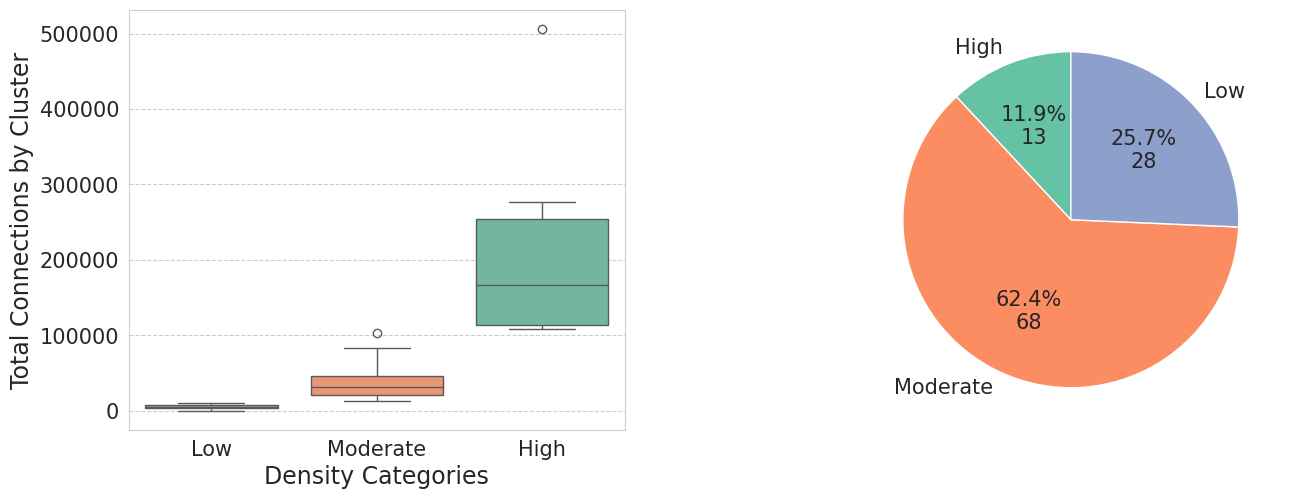

In [12]:
# Calculate the counts of each density category
density_counts = agg_cluster['density'].value_counts()
density_counts = density_counts.reindex(['High', 'Moderate', 'Low'])

# Set colors for the pie chart using 'Set2' color palette
colors = sns.color_palette("Set2", len(density_counts))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Boxplot -------------------------------------------------------

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Create boxplot
axes[0] = sns.boxplot(x=agg_cluster.density, y=agg_cluster.conn_count, hue=agg_cluster.density, order=density_choices, palette=sns.color_palette("Set2", 3), ax=axes[0])

# Format boxplot
axes[0].tick_params(labelsize=15)
axes[0].set_xlabel("Density Categories", fontsize=17)
axes[0].set_ylabel("Total Connections by Cluster", fontsize=17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# Pie chart -------------------------------------------------------

# Create pie chart
wedges, texts, autotexts = axes[1].pie(density_counts, labels=density_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 15})

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{density_counts.iloc[i]}")

# Add title and legend
#axes[1].legend(title="Density", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.35, top=0.95, wspace=0.4)

# Save the figure
plt.savefig('combined_plots.png', format='png', dpi=300)

plt.show()

In [15]:
dim_bs.columns

Index(['dummy_id', 'name_norm', 'type_norm', 'latitude', 'longitude'], dtype='object')

In [20]:
map_cluster = pd.merge(
    df_cluster, 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_u', right_on = 'dummy_id'
).merge( 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_v', right_on = 'dummy_id'
)

In [31]:
map_cluster.columns

Index(['dummy_id_u', 'dummy_id_v', 'cluster', 'latitude_u', 'longitude_u',
       'name_norm_u', 'type_norm_u', 'latitude_v', 'longitude_v',
       'name_norm_v', 'type_norm_v'],
      dtype='object')

In [32]:
map_cluster = pd.merge(
    df_cluster[['dummy_id_u', 'dummy_id_v', 'cluster']].drop_duplicates(), 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_u', right_on = 'dummy_id'
).merge( 
    dim_bs[['dummy_id', 'latitude', 'longitude', 'name_norm', 'type_norm']], 
    left_on = 'dummy_id_v', right_on = 'dummy_id'
).rename(
    columns = {
        'latitude_x': 'latitude_u', 
        'longitude_x': 'longitude_u', 
        'name_norm_x': 'name_norm_u', 
        'type_norm_x': 'type_norm_u',
        'latitude_y': 'latitude_v', 
        'longitude_y': 'longitude_v', 
        'name_norm_y': 'name_norm_v', 
        'type_norm_y': 'type_norm_v'        
    }
).drop(
    columns = ['dummy_id_x', 'dummy_id_y'],
    axis = 1
).merge(
    agg_cluster[['cluster', 'density']]
)

In [40]:
mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

bus_stop_clustered = pd.merge(
    clusters,
    dim_bs
)

markers = []
for density in density_choices:

    feature_group = folium.FeatureGroup(density)
    cluster_numbers = folium.FeatureGroup(f'Cluster Numbers ({density})')
    
    centers = []
    points = []    
    idx = list(agg_cluster.query(f"density == '{density}'").cluster.drop_duplicates())
    for index, conn in map_cluster.query(f"cluster == {idx}").filter(['latitude_u', 'longitude_u', 'name_norm_u', 'type_norm_u', 'latitude_v',
           'longitude_v', 'name_norm_v', 'type_norm_v', 'cluster']).drop_duplicates().iterrows():
        
        u = [conn['latitude_u'], conn['longitude_u']]
        v = [conn['latitude_v'], conn['longitude_v']]
        line = folium.PolyLine([u, v], color = 'red', weight = 1.0).add_to(feature_group)
        centre = bus_stop_clustered.query(f"centre == 1 and cluster == {conn['cluster']}").filter(['latitude', 'longitude']).values.tolist()[0]
        if centre not in centers:
            folium.Circle(centre, popup = conn["cluster"],
                radius = 600, color = 'blue', fill_color = 'blue', fill = True, opacity = 1, fill_opacity = 0.1, weight = 1.0).add_to(feature_group)
            folium.map.Marker(
                centre,
                icon=folium.DivIcon(
                    icon_size=(150,36),
                    icon_anchor=(0,0),
                    html='<div style="font-size: 12pt; font-weight: bold; color: black">%s</div>' % conn['cluster'],
                    )
                ).add_to(cluster_numbers)            
            centers.append(centre)
            
        if u not in points:
            markers.append(folium.Circle(u, popup = conn["name_norm_u"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(u)
            
        if v not in points:
            markers.append(folium.Circle(v, popup = conn["name_norm_v"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(v)
            
        mapa.add_child(feature_group)
        mapa.add_child(cluster_numbers)

folium.GeoJson(gpd.read_file('maps/PR_Municipios_2022.shp').query("NM_MUN == 'Curitiba'"),
             style_function=lambda x: {'color': 'black', 'fillOpacity': 0, 'weight': 1.5}).add_to(mapa)        
        
mapa.add_child(folium.LayerControl())
mapa.keep_in_front(*markers)
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "density_map.html")
web.open_new_tab("density_map.html")

False

In [38]:
clusters.head()

,dummy_id,centre,cluster
0,108123.0,0,0
1,108124.0,0,0
2,150270.0,0,0
3,150271.0,0,0
4,150272.0,0,0
